In [1]:
import pandas as pd

In [2]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'target_x', 'target_y', 'target_z'])

# Load the Training/Test sets into pandas DataFrames
df_train : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TR.csv', delimiter=',')
df_test  : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TS.csv', delimiter=',')

# Print the head of the loaded data
print(df_train.head())
print(df_test.head())

   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.917280 -0.712727 -0.989904  0.992819  0.993649  0.995543  0.711074   
1   2 -0.858784  0.998755 -0.998396  0.999909  0.316503 -0.951897 -0.163139   
2   3 -0.990441  0.958726 -0.998675  0.997216  0.987166  0.356483 -0.279689   
3   4  0.937117  0.984474 -0.612420  0.999812  0.728623 -0.539962 -0.165939   
4   5 -0.906628 -0.884567 -0.932487  0.941037  0.978134  0.998179  0.749606   

       col8      col9     col10   target_x   target_y   target_z  
0  0.407645 -0.688548  0.616890   7.897453 -35.936382  21.077147  
1  0.980982  0.661759 -0.800155  -9.330632  19.901571   6.069154  
2  0.599163 -0.684630  0.922901  14.849400   3.374090  19.667479  
3  0.999352 -0.921444 -0.974766 -46.591854  13.734777  17.953600  
4 -0.590599 -0.508268  0.691798   8.217500 -45.885254  14.894251  
   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.983589  0.989514 -0.998539  0.99944

In [3]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
    0: {
        'hidden_units': [64, 80, 90], 
        'patience': [10,15,30],
        'learning_rate': [float(i/1000) for i in range(5,9)],
        'batch_size': [17, 32, 64],
        'epochs': [int(450+epochs) for epochs in range(0,100,50)],
        'weight_decay': [float(i/10000) for i in range(1,5)] + [0.001],
        'momentum': [0.05, 0.1, 0.6],
        'activation': ['tanh'],
        'nesterov': [True, False],
        'output_activation': ['linear']    
        }
}


In [4]:
# Saving the ID columns
df_id_train: pd.DataFrame = df_train['id']
df_id_test: pd.DataFrame = df_test['id']

# Drop the ID columns
df_train = df_train.drop(columns=['id'],axis=1).copy(deep=True)
df_test = df_test.drop(columns=['id'],axis=1).copy(deep=True)

# Split of columns and rows (0.8/0.2) into: TR set and Internal TS set
x_train, y_train, x_internal_test, y_internal_test = data_handler.split_data(
    data=df_train,
    cols_name_split=['target_x','target_y','target_z'],
    rows_split_perc=0.8
)

# Split on columns
x_test, y_test = data_handler.split_data(data=df_test, cols_name_split=['target_x','target_y','target_z'])

# Print of the shapes
print(f"[IDs TR SET]: " + str(df_id_train.shape))
print(f"[IDs TS SET]: " + str(df_id_test.shape))
print(f"[TR SET - x]: " + str(x_train.shape))
print(f"[TR SET - y]: " + str(y_train.shape))
print(f"[Internal TS SET - x]: " + str(x_internal_test.shape))
print(f"[Internal TS SET - y]: " + str(y_internal_test.shape))
print(f"[TS SET - x]: " + str(x_test.shape))
print(f"[TS SET - y]: " + str(y_test.shape))

[IDs TR SET]: (1000,)
[IDs TS SET]: (900,)
[TR SET - x]: (800, 10)
[TR SET - y]: (800, 3)
[Internal TS SET - x]: (200, 10)
[Internal TS SET - y]: (200, 3)
[TS SET - x]: (900, 10)
[TS SET - y]: (900, 3)


In [5]:
from sklearn.model_selection import KFold
from api.keras.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: BinaryNN = None

# Different values per dataset
trials = 100
k = 5

# Search of the best Hyperparameters
X = x_train.values.astype(dtype=float)
y = y_train.values.astype(dtype=float)

# K-fold Cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Sets all the combinations of the entire set of parameters
#data_handler.set_params_combinations(params=param_space[dataset_i])

# Gets the list with the combinations of all the parameters
#params_combinations = data_handler.get_params_combinations()

# For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
#for trial, params in enumerate(params_combinations):
for trial in range(trials):

    # Choose random hyperparameters
    params = data_handler.random_dictionary(params=param_space[0])

    # Creation of the Neural Network object
    nn_i = BinaryNN(params=params, monk_i=trial+1, trial=+1)

    nn_i.create_model(n_hidden_layers=2)
                    
    # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
    for train_index, val_index in kfold.split(X, y):
        x_kfold_train, x_kfold_val = X[train_index], X[val_index]
        y_kfold_train, y_kfold_val = y[train_index], y[val_index]

        nn_i.fit(
            x_train=x_kfold_train,
            y_train=y_kfold_train,
            x_val=x_kfold_val,
            y_val=y_kfold_val
        )

        nn_i.evaluate(
            x_train=x_kfold_train,
            y_train=y_kfold_train,
            x_val=x_kfold_val,
            y_val=y_kfold_val
        )

    # Case of first assignment
    if nn is None:
        nn = nn_i
    
    # Print the results of this trial
    print("\n------------------ Current Hyperparameters ------------------")
    nn_i.print_training_info()
    print("------------------ CUP Best Hyperparameters -----------------")
    nn.print_training_info()
    print("\n\n")

    # Update best hyperparameters if: no overfitting AND (higher mean VL accuracy OR (equal mean AND
    #if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy: #\
    #    and (
    #        nn.mean_vl_accuracy < nn_i.mean_vl_accuracy \
    #        or (
    #            nn.mean_vl_accuracy == nn_i.mean_vl_accuracy \
    #            and nn.mean_tr_accuracy < nn_i.mean_tr_accuracy
    #        )
    #    ):
        #nn = nn_i
    
    # Case of higher mean VL accuracy AND NO Overfitting
    if nn_i.mean_vl_accuracy < nn.mean_vl_accuracy: 
        #\
        #and (
        #    abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < abs(nn.mean_tr_accuracy - nn.mean_vl_accuracy) \
        #    or abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02
        #):
        nn = nn_i
    
    # Exit case
    if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
        and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
        and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
        nn = nn_i
        break

# Print output
print(f"### Best Hyperparameters for CUP ###")
nn.print_training_info()
print("\n\n")







------------------ Current Hyperparameters ------------------
 Monk:                          1
 Trial:                         1
 Hyperparameters:               {'hidden_units': 80, 'patience': 10, 'learning_rate': 0.007, 'batch_size': 64, 'epochs': 450, 'weight_decay': 0.003, 'momentum': 0.1, 'activation': 'tanh', 'nesterov': True, 'output_activation': 'linear'}
 Mean Training MSE:             0.9670857667922974
 Mean Validation MSE:           1.0101079940795898
 Mean Training MEE:             0.9288273930549622
 Mean Validation MEE:           0.9624529242515564
 Standard Deviation VL MEE:     0.12320503965067901
 Variance VL MEE:               0.015179481795325387
 Standard Deviation VL MEE:     0.20624720032613317
 Variance VL MEE:               0.04253790764236811

------------------ CUP Best Hyperparameters -----------------
 Monk:                          1
 Trial:                         1
 Hyperparameters:               {'hidden_units': 80, 'patience': 10, 'learning_rate'

KeyboardInterrupt: 


### Best Hyperparameters for CUP ###
 Monk:                          44
 Trial:                         1
 Hyperparameters:               {'hidden_units': 90, 'patience': 30, 'learning_rate': 0.008, 'batch_size': 17, 'epochs': 500, 'weight_decay': 0.0001, 'momentum': 0.1, 'activation': 'tanh', 'nesterov': False, 'output_activation': 'linear'}
 Mean Training MSE:             0.13315508514642715
 Mean Validation MSE:           0.18562046438455582
 Mean Training MEE:             0.48098737597465513
 Mean Validation MEE:           0.5279311835765839
 Standard Deviation VL MEE:     0.1129006692487447
 Variance VL MEE:               0.012746561116814447
 Standard Deviation VL MEE:     0.12993596370897043
 Variance VL MEE:               0.016883354664978877



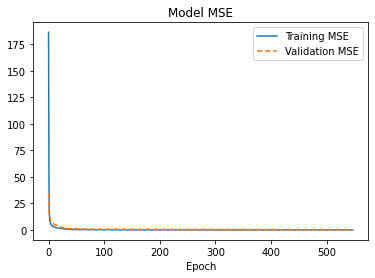

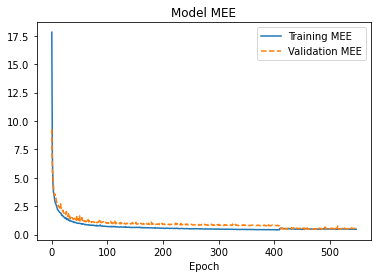

In [6]:
# Print best hyperparameters
print(f"\n### Best Hyperparameters for CUP ###")
nn.print_training_info()
nn.print_plot()


# BEST BEST BEST CURVES 'hidden_units': 30, 'patience': 30, 'learning_rate': 0.002, 'batch_size': 65, 'epochs': 350, 'weight_decay': 0.001, 'weight_init': 'glorot_normal', 'momentum': 0.0, 'activation': 'linear', 'output_activation': 'linear'}
# Monk:                     6
# Trial:                    1
# Hyperparameters:          {'hidden_units': 64, 'patience': 30, 'learning_rate': 0.003, 'batch_size': 16, 'epochs': 450, 'weight_decay': 6e-05, 'momentum': 0.5, 'activation': 'tanh', 'nesterov': False, 'output_activation': 'linear'}
# Mean Training MSE:        0.2653432160615921
# Mean Validation MSE:      0.48080223202705386
# Mean Training MEE:        0.7562257528305054
# Mean Validation MEE:      0.965958833694458

### Best Hyperparameters for CUP ###
#Monk:                     18
# Trial:                    1
# Hyperparameters:          {'hidden_units': 60, 'patience': 30, 'learning_rate': 0.03, 'batch_size': 32, 'epochs': 400, 'weight_decay': 0.0001, 'momentum': 0.0, 'activation': 'tanh', 'nesterov': False, 'output_activation': 'linear'}
# Mean Training MSE:       0.20921985805034637
# Mean Validation MSE:     0.4135563313961029
# Mean Training MEE:   0.6518718361854553
# Mean Validation MEE: 0.8760325312614441

### Best Hyperparameters for CUP ###
#Monk:                     5
# Trial:                    1
# Hyperparameters:          {'hidden_units': 64, 'patience': 30, 'learning_rate': 0.03, 'batch_size': 16, 'epochs': 500, 'weight_decay': 1e-05, 'momentum': 0.0001, 'activation': 'tanh', 'nesterov': True, 'output_activation': 'linear'}
# Mean Training MSE:        0.14074430167675017
# Mean Validation MSE:      0.34424884915351867
# Mean Training MEE:        0.560929274559021
# Mean Validation MEE:      0.7960572957992553


# Retraining best model

In [7]:
# Retraining the model on the whole dataset
nn.fit(
        x_train=X,
        y_train=y,
        retraining=True   # after kfold retrain on ALL dataset without fold and val set
    )

# Print values
print(f"\n### Retraining of CUP ###")
nn.print_training_info()


### Retraining of CUP ###
 Monk:                          44
 Trial:                         1
 Hyperparameters:               {'hidden_units': 90, 'patience': 30, 'learning_rate': 0.008, 'batch_size': 17, 'epochs': 500, 'weight_decay': 0.0001, 'momentum': 0.1, 'activation': 'tanh', 'nesterov': False, 'output_activation': 'linear'}
 Mean Training MSE:             0.13315508514642715
 Mean Validation MSE:           0.18562046438455582
 Mean Training MEE:             0.48098737597465513
 Mean Validation MEE:           0.5279311835765839
 Standard Deviation VL MEE:     0.1129006692487447
 Variance VL MEE:               0.012746561116814447
 Standard Deviation VL MEE:     0.12993596370897043
 Variance VL MEE:               0.016883354664978877



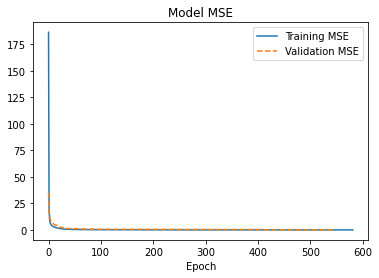

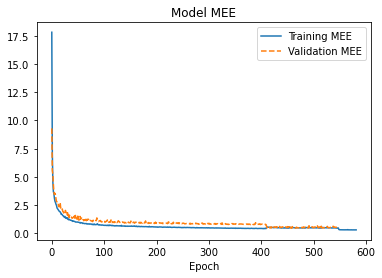

In [8]:
nn.print_plot()

In [9]:
import keras.backend as K

# Evaluation of the Model
print(x_test.shape)
print(y_test.shape)

X = x_internal_test.values
y = y_internal_test.values

y_pred = nn.predict(x_its=X, y_its=y)

# Prints the results obtained
#print(nn)

print("Mean Euclidean Error (Internal) test set:", round(K.eval(y_pred), 2))

(900, 10)
(900, 3)
7/7 [==============================] - 1s 5ms/step
Mean Euclidean Error (Internal) test set: 0.61
